<a href="https://colab.research.google.com/github/Gooogr/YOLO_Webcam_Tracker/blob/yolov4_tiny/model_files/Train_tiny_yolov4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc #garbage collector
import ast # operate with string representation of list
import os
import fnmatch
import re

import pandas as pd
import numpy as np
import cv2

from google.colab import files
from google.colab.patches import cv2_imshow

In [2]:
! pip install -q awscli

     |████████████████████████████████| 3.3MB 2.3MB/s 
     |████████████████████████████████| 6.6MB 45.5MB/s 


In [3]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Thu Aug 27 16:43:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Passing IPython variables as arguments to bash commands <br>
https://stackoverflow.com/questions/35497069/passing-ipython-variables-as-arguments-to-bash-commands

## Utils

In [4]:
#--- Dataset downloading utils ---
def yolo2voc(data, w, h):
  '''
  Convert boundary box from YOLO format to VOC
  '''
  bbox_width = float(data[3]) * w
  bbox_height = float(data[4]) * h
  center_x = float(data[1]) * w
  center_y = float(data[2]) * h
  x_min = int(center_x - (bbox_width / 2))
  y_min = int(center_y - (bbox_height / 2))
  x_max = int(center_x + (bbox_width / 2))
  y_max = int(center_y + (bbox_height / 2))
  return(x_min, y_min, x_max, y_max)

def show_data_sample(dir_path):
  '''
  Show random sample from dataset with boundary box
  '''
  txt_files = []
  img_files = []
  for txt_file in os.listdir(dir_path):
      if fnmatch.fnmatch(txt_file, '*.txt'):
        txt_files.append(txt_file)
  print('Data pairs amount:', len(txt_files))

  sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

  txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
  img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
  height = img_sample.shape[0]
  width = img_sample.shape[1]
  for line in txt_sample.readlines():
      yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
      voc_bndbox = yolo2voc(yolo_bndbox, width, height)
      img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
  img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
  cv2_imshow(img_sample)

## Dataset downloading

In [5]:
def setup_OIDv4Toolkit():
  # Clone tookit for Open Image Dataset v4
  ! git clone https://github.com/theAIGuysCode/OIDv4_ToolKit
  % cd OIDv4_ToolKit
  ! pip install -q -r  requirements.txt

In [6]:
setup_OIDv4Toolkit()

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 34.09 MiB | 41.56 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/OIDv4_ToolKit


In [8]:
# Don't forget to specify --classes and --limit keys
# Don't change --multiclasses key value. YOLO requires that all files be in the same folder
! python3 main.py downloader -y \
 --classes Human_face Human_hand  \
 --type_csv train \
 --limit 100 \
 --multiclasses 1


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Human face', 'Human hand'] together.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Automatic download.
...145%, 0 MB, 60293 KB/s, 0 seconds passed
[DOWNLOAD] | File 

In [9]:
%%writefile classes.txt
Human face
Human hand

Overwriting classes.txt


In [10]:
# Convert annotations to normalazied YOLO version. 
! python convert_annotations.py

Currently in subdirectory: train
Converting annotations for class:  Human face_Human hand
100% 193/193 [00:06<00:00, 30.28it/s]


In [11]:
! pwd

/content/OIDv4_ToolKit


In [12]:
# Remove old labels. Count files amount in the dataset (images + labels).
# Name of dataset folder corresponds to the selected labels types: <Class name 1>_<Class name 2>_ ...
! rm -r /content/OIDv4_ToolKit/OID/Dataset/train/'Human face_Human hand'/Label
! ls /content/OIDv4_ToolKit/OID/Dataset/train/'Human face_Human hand'/ | wc -l

386


In [13]:
# Move dataset folder to the root of working directory
! mkdir /content/dataset
! mv /content/OIDv4_ToolKit/OID/Dataset/train/'Human face_Human hand'/* /content/dataset

Data pairs amount: 193


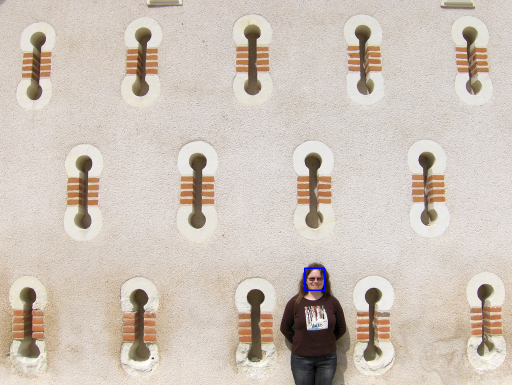

In [15]:
dir_path = '/content/dataset' 
show_data_sample(dir_path)

In [ ]:
# def create_yolo_bbox(x):
#     x, y, width, height = list(map(int, ast.literal_eval(x)))
#     x_c = (x + width // 2) / 1024
#     y_c = (y + height // 2) / 1024
#     return ([x_c, y_c, (width / 1024), (height / 1024)])

# def write_yolo_txt(save_dir):
#     unique_ids = train_df['image_id'].unique()
#     for img_id in unique_ids:
#         df_sample = train_df[train_df['image_id'] == img_id]
#         temp_ser = df_sample['yolo_bbox']

#         file = open(os.path.join(save_dir, (img_id + ".txt")), "w")
#         for bbox in temp_ser:
#             row = ' '.join(str(item) for item in bbox)
#             file. write('0 ') #class number
#             file.write(row)
#             file.write('\n')
#         file.close()

# def show_data_sample(dir_path):
#   '''
#   Show random sample from dataset with boundary box
#   '''
#   txt_files = []
#   img_files = []
#   for txt_file in os.listdir(dir_path):
#       if fnmatch.fnmatch(txt_file, '*.txt'):
#         txt_files.append(txt_file)
#   print('Data pairs amount:', len(txt_files))

#   sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

#   txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
#   img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
#   height = img_sample.shape[0]
#   width = img_sample.shape[1]
#   for line in txt_sample.readlines():
#       #print(re.split('\s',line)[0:5])
#       yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
#       voc_bndbox = yolo2voc(yolo_bndbox, width, height)
#       img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
#   img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
#   cv2_imshow(img_sample)


# def yolo2voc(data, w, h):
#   '''
#   Convert boundary box from YOLO format to VOC
#   '''
#   bbox_width = float(data[3]) * w
#   bbox_height = float(data[4]) * h
#   center_x = float(data[1]) * w
#   center_y = float(data[2]) * h
#   x_min = int(center_x - (bbox_width / 2))
#   y_min = int(center_y - (bbox_height / 2))
#   x_max = int(center_x + (bbox_width / 2))
#   y_max = int(center_y + (bbox_height / 2))
#   return(x_min, y_min, x_max, y_max)

In [ ]:
# MAIN_PATH = '/content/'
# TRAIN_DIR_PATH = '/content/train'
# TEST_DIR_PATH = '/content/test'

## Setting up YOLO Darknet

In [16]:
% cd /content

/content


In [17]:
def make_darknet():
  '''
  Run this function if darknet wasn`t setted up your root project folder
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

Check saving rules in ```/content/darknet/src/detector.c```, lines 384 - 403

```
 if (iteration >= (iter_save + 1000) || iteration % 1000 == 0) {
     sprintf(buff, "%s/%s_%d.weights", backup_directory, base, iteration);
 if (iteration >= (iter_save_last + 100) || (iteration % 100 == 0 && iteration > 1)) {
     sprintf(buff, "%s/%s_last.weights", backup_directory, base);
```
Change it if you need, but don't forget to ```! make``` it arter that.



In [18]:
%%capture
make_darknet()

In [19]:
def download_pretrained_data():
  # YOLOv4
  # cfg files have already been in cfg folder
  ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
  ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

  # YOLOv4 tiny
  #! wget --quiet https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg
  ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights


  

In [20]:
download_pretrained_data()

In [21]:
def predict_sample(tiny=True):
    ! chmod 777 ./darknet
    if tiny:
        ! ./darknet detector test cfg/coco.data cfg/yolov4-tiny.cfg yolov4-tiny.weights data/horses.jpg 
    else:
         ! ./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/horses.jpg 
    image = cv2.imread('predictions.jpg')
    cv2_imshow(image)

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 max              

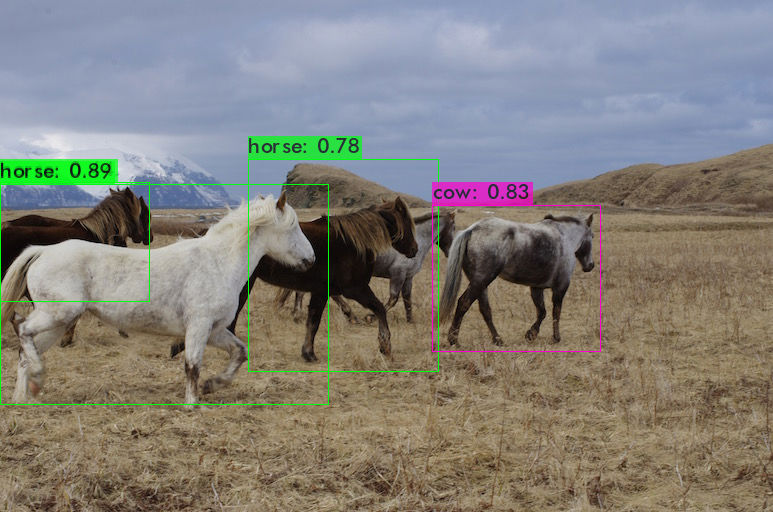

In [22]:
# check that we get working YOLO version
predict_sample()

### Prepare config files

In [36]:
% cd /content/
! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py

--2020-08-27 16:55:36--  https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657 [text/plain]
Saving to: ‘splitTrainAndTest.py’

splitTrainAndTest.p 100%[===================>]     657  --.-KB/s    in 0s      

2020-08-27 16:55:37 (48.9 MB/s) - ‘splitTrainAndTest.py’ saved [657/657]



In [37]:
# Create train and test(validate) txt files. Split ratio will be 0.1
! python3 splitTrainAndTest.py /content/dataset

In [40]:
! mkdir /content/darknet/custom_config_files
% cd /content/darknet/custom_config_files

mkdir: cannot create directory ‘/content/darknet/custom_config_files’: File exists
/content/darknet/custom_config_files


> obj.names

One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

In [41]:
%%writefile obj.names
Human face
Human hand

Writing obj.names


> yolo.data

Specify classes amount. Check pathes to other files:<br>
classses = *amount of your classes*<br>
valid  = /content/test.txt<br>
names = /content/yolo_config_files/obj.names<br>
backup = /content/yolo_weights<br>
train  = /content/train.txt<br>

We will create backup folder later

In [42]:
%%writefile yolo.data
classses = 2
valid = /content/test.txt
names =  /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train = /content/train.txt

Writing yolo.data


> yolov4.cfg

How to configure cfg file<br>
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

In [44]:
#Generate anchors for cfg file
def generate_anchors():
    % cd /content/darknet
    ! chmod 777 ./darknet
    ! ./darknet detector calc_anchors \
    ./custom_config_files/yolo.data -num_of_clusters 2 -width 416 -height 416 -show


In [52]:
##########################
####UNDER CONSTRUCTION#### 
##########################

In [45]:
generate_anchors()

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0

 num_of_clusters = 2, width = 416, height = 416 
classes: Using default '1'
 read labels from 173 images 
 loaded 	 image: 173 	 box: 500
 all loaded. 

 calculating k-means++ ...

 iterations = 9 


counters_per_class = 219, 22248

 avg IoU = 43.06 % 

Saving anchors to the file: anchors.txt 
anchors =  23, 34,  92,120
Unable to init server: Could not connect: Connection refused

(clusters:3421): Gtk-WARNING **: 17:32:31.441: cannot open display: 


In [ ]:
#DONT FORGET TO ADD THESE ANCHORS TO .CFG FILE!

In [46]:
% cd /content/darknet/custom_config_files/
! wget --quiet -c  https://raw.githubusercontent.com/Gooogr/YOLO_Webcam_Tracker/yolov4_tiny/model_files/yolov4-tiny-custom.cfg

/content/darknet/custom_config_files


In [47]:
# Create empty directiry for saving weights during the training
! mkdir /content/yolo_weights

In [51]:
# Safety measure to prevent yolo training start after massive pushing Shift + Enter
assert False

AssertionError: ignored

### Train YOLOv4

In [ ]:
# # Get tiny yolo convolutions layers weights
# % cd /mydrive/YOLO_toolkit/darknet
# ! ./darknet partial \
# /mydrive/YOLO_toolkit/darknet_files/yolov3tiny_train.cfg \
# yolov3-tiny.weights yolov3-tiny.conv.15 15

#### Train from scratch

In [ ]:
def train_yolo_from_scratch():
    # Train YOLO
    % cd /content/darknet
    ! ./darknet detector train \
    /content/yolo_config_files/yolo.data \
    /content/yolo_config_files/yolov4.cfg \
    ./yolov4.conv.137 > /content/temp_train.log -dont_show  

In [ ]:
# train_yolo_from_scratch()

#### Continue training

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # select file from google disk or use curl/wget if you store it somewhere else 
# % cp /content/drive/'My Drive'/colab_notebooks/Kaggle_Global_Wheat_Detection/yolov4_1300.weights /content/yolo_weights
# ! mv /content/yolo_weights/yolov4_1300.weights /content/yolo_weights/yolov4_last.weights

In [ ]:
# def continue_yolo_training():
#     # Continue YOLO training
#     % cd /content/darknet
#     ! ./darknet detector train \
#     /content/yolo_config_files/yolo.data \
#     /content/yolo_config_files/yolov4.cfg \
#     /content/yolo_weights/yolov4_last.weights > /content/temp_train.log -dont_show  


In [ ]:
# continue_yolo_training()
